<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 14: ускорение тренировки и применения сетей
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

В рамках семинара разберемся в основных проблемах с производительностью, посмотрим, как учить сети на нескольких GPU и научимся квантовать сети.

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision

Установить их можно командой:
```bash
pip3 install --user opencv-python torch torchvision
```

In [2]:
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt

import seminar

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.3.1
Use CUDA


In [14]:
# Debug.
import imp
seminar = imp.reload(seminar)

# Создание корпуса

Total dataset size: 10000
Used dataset size: 1000


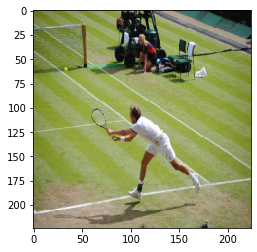

In [4]:
info_dataset = seminar.ImageNetDataset("imagenetv2-matched-frequency")
print("Total dataset size: {}".format(len(info_dataset)))

dataset = seminar.ImageNetDataset("imagenetv2-matched-frequency", num_samples=1000, to_tensor=True)
print("Used dataset size: {}".format(len(dataset)))

image, label = info_dataset[random.randrange(0, len(info_dataset))]
plt.imshow(image)
plt.show()

# Простые способы ускорения вывода

In [8]:
model = torchvision.models.resnet101(pretrained=True)
if USE_CUDA:
    model.cuda()
seminar.model_info(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Простой dataloader

In [65]:
dataloader = torch.utils.data.DataLoader(dataset)
seminar.eval_model(model, dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.24it/s]

Inference speed: 23.130 ms per sample
Top 1 accuracy: 0.611
Top 5 accuracy: 0.838


### Увеличим размер batch-а
За счет праллелизма большой batch обрабатывается быстрее нескольких маленьких.

In [68]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=32)
seminar.eval_model(model, dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.46it/s]

Inference speed: 9.256 ms per sample
Top 1 accuracy: 0.611
Top 5 accuracy: 0.838


### Увеличим число процессов подготовки данных
Изначально данные загружались и форматировались в том же процессе, что и тренировка. Во время подготовки данных, нейронная сеть простаивала. Теперь данные будут готовиться в других процессах параллельно с применением сети.

In [10]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=32,
                                         num_workers=4)
seminar.eval_model(model, dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.27it/s]

Inference speed: 3.459 ms per sample
Top 1 accuracy: 0.611
Top 5 accuracy: 0.838


### Включим привязку памяти (page-locked memory aka "pinned" memory)
http://www.orangeowlsolutions.com/archives/443

В оперативной памяти резервируется область, куда кладутся данные для обработки. При этом не используется механизм виртуальной памяти, что ускоряет обмен данными между CPU и GPU.

In [11]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=32,
                                         num_workers=4,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model, dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.06it/s]

Inference speed: 3.187 ms per sample
Top 1 accuracy: 0.611
Top 5 accuracy: 0.838


### Воспользуемся половинной точностью (half precision, FP16)
Некоторые GPU поддерживают быстрые вычисления в половинной точности. Можно конертировать веса модели и данные во float16 перед применением. При этом качество предсказаний может ухудшиться.

In [16]:
model_fp16 = torchvision.models.resnet101(pretrained=True)
model_fp16 = model_fp16.half()
if USE_CUDA:
    model_fp16.cuda()
dataset_fp16 = seminar.ImageNetDataset("imagenetv2-matched-frequency",
                                       num_samples=1000, to_tensor=True, fp16=True)
dataloader = torch.utils.data.DataLoader(dataset_fp16,
                                         batch_size=32,
                                         num_workers=4,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model_fp16, dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.05it/s]

Inference speed: 3.539 ms per sample
Top 1 accuracy: 0.610
Top 5 accuracy: 0.838
